In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [2]:
file = open('text.txt','r',encoding='utf8')

In [3]:
#Store file in list 
lines = []
for i in file:
  lines.append(i)

In [4]:
#Convert list to string
data = ""
for i in lines:
  data=" ".join(lines)

In [5]:
#Replace unnecessary stuff with space
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '').replace('"', '').replace(',', '')

In [6]:
#Remove unnecessary spaces
data = data.split() 
data = ' '.join(data)
data[:500]

'The Project Gutenberg eBook of The Adventures of Sherlock Holmes by Arthur Conan Doyle This eBook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org. If you are not located in the United States you will have to check the laws of the country where you are locat'

In [7]:
len(data)

570593

In [8]:
#Apply tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

#Saving tokenizer for predict funct
pickle.dump(tokenizer, open('token.pkl','wb'))

In [9]:
#converts text/string to numeric representation
seq_data = tokenizer.texts_to_sequences([data])[0] 
seq_data[:10]

[1, 144, 129, 875, 4, 1, 1086, 4, 127, 35]

In [10]:
len(seq_data) #This length is less than actual because many words are repeated 
# & each unique word gets 1 numeric representation also it filters any punctuation & white space

110612

In [11]:
# word_index+1 bcz index 0 reserved for padding 
vocab_size = len(tokenizer.word_index) + 1 
print(vocab_size) #these much unique words in our text

9280


In [12]:
seq = []
for i in range(3, len(seq_data)):
  words = seq_data[i-3:i+1]
  seq.append(words)

print("The length of Sequences are: ",len(seq))
seq = np.array(seq)
seq[:10]

The length of Sequences are:  110609


array([[   1,  144,  129,  875],
       [ 144,  129,  875,    4],
       [ 129,  875,    4,    1],
       [ 875,    4,    1, 1086],
       [   4,    1, 1086,    4],
       [   1, 1086,    4,  127],
       [1086,    4,  127,   35],
       [   4,  127,   35,   44],
       [ 127,   35,   44,  643],
       [  35,   44,  643, 2659]])

In [13]:
X=[]
Y=[]

for i in seq:
  X.append(i[0:3])
  Y.append(i[3])

X = np.array(X)
Y = np.array(Y)

In [14]:
print("Data: ", X[:10])
print("Response: ", Y[:10])

Data:  [[   1  144  129]
 [ 144  129  875]
 [ 129  875    4]
 [ 875    4    1]
 [   4    1 1086]
 [   1 1086    4]
 [1086    4  127]
 [   4  127   35]
 [ 127   35   44]
 [  35   44  643]]
Response:  [ 875    4    1 1086    4  127   35   44  643 2659]


In [15]:
y = to_categorical(Y, num_classes= vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
#Creating Model
model= Sequential()
model.add(Embedding(vocab_size,10,input_length=3)) #3 input arguments 
                                                   # - 1st input dimension which is size of vocabulary in my text data
                                                   # - 2nd output dimension which is size of vector space in which words will be embedded
                                                                                          #size of word vector for each word will be 10.
                                                   # - 3rd : use 3 words to predict next word
model.add(LSTM(1000, return_sequences=True))                   #1st parameter is no. of units i.e. dimensionality of the output space.
                                                               # return_sequences = True indicates I am creating next LSTM layer
model.add(LSTM(1000))
model.add(Dense(1000, activation='relu'))                      # 1000 units- vocab_size - I want my output within this vocabulary
                                                               # ReLU - converts negative value to 0 and keeps +ve as it is
model.add(Dense(vocab_size, activation = 'softmax'))           # softmax - scales numbers into probabilities 

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             92800     
                                                                 
 lstm (LSTM)                 (None, 3, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 9280)              9289280   
                                                                 
Total params: 22,431,080
Trainable params: 22,431,080
Non-trainable params: 0
_________________________________________________________________


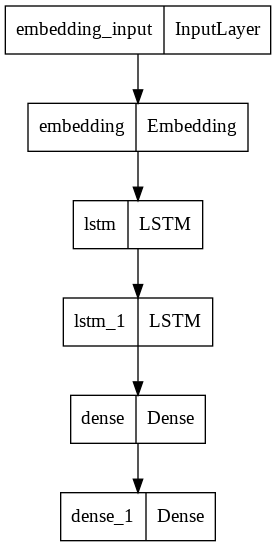

In [18]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(model, to_file = 'plot.png', show_layer_names = True)

In [19]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate= 0.001))
# Loss function as categorical cross entropy which is used for multi-class classification task 
# i.e.we have several possible outputs of which my model has to choose one.
# Adam optimizer to update the weights iteratively based on training 

In [20]:
from keras.callbacks import ModelCheckpoint,EarlyStopping 
mc=ModelCheckpoint(filepath="/content/saved_model/best_model.h5", # best model & weights would go here
                   monitor="loss",
                   verbose=1,                 #see' the training progress for each epoch only once=1 time
                   save_best_only=True) 
model.fit(X, y, epochs=5,batch_size =1024,callbacks=[mc]) 

Epoch 1/5
109/109 [==============================] - ETA: 0s - loss: 7.0081
Epoch 1: loss improved from inf to 7.00811, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 582s 5s/step - loss: 7.0081
Epoch 2/5
109/109 [==============================] - ETA: 0s - loss: 6.6015
Epoch 2: loss improved from 7.00811 to 6.60152, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 562s 5s/step - loss: 6.6015
Epoch 3/5
109/109 [==============================] - ETA: 0s - loss: 6.5733
Epoch 3: loss improved from 6.60152 to 6.57330, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 560s 5s/step - loss: 6.5733
Epoch 4/5
109/109 [==============================] - ETA: 0s - loss: 6.4164
Epoch 4: loss improved from 6.57330 to 6.41638, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 562s 5s/step - loss: 6.4164
Epoch 5/5
109/109 [=

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping 
mc=ModelCheckpoint(filepath="/content/saved_model/best_model.h5", # best model & weights would go here
                   monitor="loss",
                   verbose=1,                 #see' the training progress for each epoch only once=1 time
                   save_best_only=True) 
model.fit(X, y, epochs=15,batch_size =1024,callbacks=[mc]) 

Epoch 1/15
109/109 [==============================] - ETA: 0s - loss: 4.6796
Epoch 1: loss improved from inf to 4.67955, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 580s 5s/step - loss: 4.6796
Epoch 2/15
109/109 [==============================] - ETA: 0s - loss: 4.4842
Epoch 2: loss improved from 4.67955 to 4.48419, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 575s 5s/step - loss: 4.4842
Epoch 3/15
109/109 [==============================] - ETA: 0s - loss: 4.2905
Epoch 3: loss improved from 4.48419 to 4.29045, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 573s 5s/step - loss: 4.2905
Epoch 4/15
109/109 [==============================] - ETA: 0s - loss: 4.0975
Epoch 4: loss improved from 4.29045 to 4.09753, saving model to /content/saved_model/best_model.h5
109/109 [==============================] - 583s 5s/step - loss: 4.0975
Epoch 5/15
109/1

In [21]:
from keras.models import load_model
model=load_model('/content/saved_model/best_model.h5') 

In [22]:
import pickle
tokenizer = pickle.load(open('token.pkl','rb')) 

In [23]:
import numpy as np
def predict(model, tokenizer, text):
  seq = tokenizer.texts_to_sequences([text])
  seq = np.array(seq)
  preds = np.argmax(model.predict(seq))
  pred_word = ""

  for key, value in tokenizer.word_index.items():
    if value == preds:
      pred_word = key
      break

  print(pred_word)
  return pred_word 

In [25]:
while(True):
  text = input("Enter your line: ")

  if text == '0':
    print("Excetution completed....")
    break

  else:
      try:
          text = text.split(" ")
          text = text[-3:]
          print(text)

          predict(model, tokenizer, text) 

      except Exception as e:
        print("Error occured: ",e)
        continue

Enter your line: the use of
['the', 'use', 'of']
the
Enter your line: not located in
['not', 'located', 'in']
the
Enter your line: The Adventures of
['The', 'Adventures', 'of']
the
Enter your line: Author: Arthur Conan
['Author:', 'Arthur', 'Conan']
Error occured:  in user code:

    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1751, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in er